## Notebook 2 - Tratamento dos Dados

**Objetivo**: realizar a limpeza e transformação dos dados de treinamento, deixando a base preparada para ser inputada nos modelos de aprendizado de máquina.

---

## 0 - Imports e funções auxiliares

In [1]:
from   pyod.models.knn import KNN
from   sklearn.ensemble import ExtraTreesClassifier
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
#Variáveis globais
to_rescale = False
drop_na = True

---

## 1 - Ingestão dos dados

In [3]:
df_train_raw = pd.read_csv("../dados/raw/treino.csv")
df_test_raw = pd.read_csv("../dados/raw/teste.csv")
df_train = df_train_raw.copy()

---

## 2 - Tratamento de valores faltantes

Não existe um consenso sobre a proporção de dados faltantes que é aceitável em uma análise, mas alguns autores argumentam que mais de 10% já pode causar algum impacto (fonte: 1). Por isso, testei diferentes abordagens para entender qual é  o melhor resultado nas análises preditivas. 

Em uma abordagem, dropei todas os registros com NA's e obtive um dataset menor do que o original.Não é o ideal, pois implica em perda de dados que podem ser importantes. Mas servirá de ponto de partida para avaliar o desempenho do modelo quando apagamos todos os registros faltantes e quando adotamos outras abordagens.

Em um segundo momento, utilizei a abordagem de inputação de valores. Para a variável número de dependentes, usei a moda (valor mais frequente). Já para o salário, usei e média.

In [4]:
df_train.isnull().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [5]:
if(drop_na):
    df_train.dropna(inplace=True)
    df_train.isnull().sum()
else:
    mode_dependent = df_train["numero_de_dependentes"].mode()
    mean_salary = df_train["salario_mensal"].mean()
    df_train["numero_de_dependentes"] = df_train["numero_de_dependentes"].fillna(mode_dependent[0])
    df_train["salario_mensal"] = df_train["salario_mensal"].fillna(mean_salary)

In [6]:
df_train.shape

(88237, 11)

In [7]:
df_train.isnull().sum()

inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

---

## 3 - Filtragem de dados

### 3.1.Filtragem de linhas

#### 3.1.1.Duplicatas

In [8]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

#### 3.1.2.Valores inconsistentes

- clientes com idade 0 ou menores de idade
- variável linhas inseguras > 1

In [9]:
condition1 = df_train["idade"] >= 18
condition2 = df_train["util_linhas_inseguras"] <= 1.0
df_train = df_train[(condition1) & (condition2)]

In [10]:
df_train.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,86122.000000,86122.000000,86122.000000,86122.000000,86122.000000,8.612200e+04,86122.000000,86122.000000,86122.000000,86122.000000,86122.000000
mean,0.061959,0.314998,51.453241,0.369580,27.067312,6.671948e+03,8.813114,0.205871,1.064676,0.185516,0.848935
std,0.241082,0.335806,14.396632,3.586883,392.805391,1.351779e+04,5.175521,3.554116,1.158093,3.541228,1.146276
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033721,41.000000,0.000000,0.143703,3.427000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.167365,51.000000,0.000000,0.296717,5.416000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.540727,62.000000,0.000000,0.482235,8.300000e+03,12.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,1.000000,103.000000,98.000000,61106.500000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 3.2.Filtragem de colunas

Na análise exploratória de dados (notebook1), descobri que as variáveis de atraso são altamente correlacionadas entre si (>98%). Portanto, como são informações redundantes, vou eliminar todas com exceção de uma das colunas.

In [11]:
cols_to_drop = ["vezes_passou_de_30_59_dias", "numero_de_vezes_que_passou_60_89_dias"]
df_train.drop(columns=cols_to_drop, axis=1, inplace=True)
df_train.columns

Index(['inadimplente', 'util_linhas_inseguras', 'idade', 'razao_debito',
       'salario_mensal', 'numero_linhas_crdto_aberto',
       'numero_vezes_passou_90_dias', 'numero_emprestimos_imobiliarios',
       'numero_de_dependentes'],
      dtype='object')

---

## 4.Seleção de atributos

Método TreeCliassifier: o primeiro passo foi treinar o algoritmo classificador com a base de dados para que ele possa aprender sobre eles. E então utilizar o atributo _feature_importances_ do objeto classificador para conhecer a importância relativa de cada uma das variáveis preditoras:

In [12]:
tree_clf = ExtraTreesClassifier()
tree_clf.fit(X = df_train.iloc[:,1:], y = df_train.iloc[:,0])
features = tree_clf.feature_importances_

In [13]:
data = {"Feature_name": df_train.iloc[:,1:].columns, 
        "Relative_importance": features*100}

feat_importance_df = pd.DataFrame(data).sort_values(by="Relative_importance", ascending=False)
feat_importance_df

,Feature_name,Relative_importance
0,util_linhas_inseguras,19.481352
2,razao_debito,18.037948
3,salario_mensal,18.016335
1,idade,14.529449
4,numero_linhas_crdto_aberto,11.156151
5,numero_vezes_passou_90_dias,9.416442
7,numero_de_dependentes,4.741949
6,numero_emprestimos_imobiliarios,4.620373


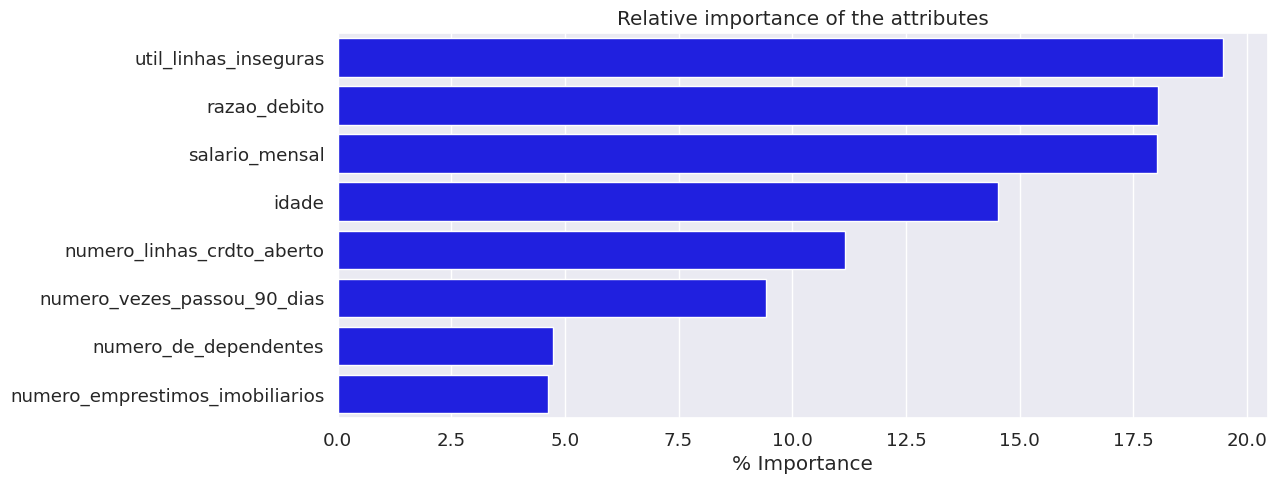

In [14]:
plt.figure(figsize = (12,5))
sns.set(font_scale = 1.2)
b = sns.barplot(x = feat_importance_df["Relative_importance"], 
                y = feat_importance_df["Feature_name"], orient = "h", color="blue")
plt.xlabel('% Importance')     
plt.ylabel('')            
plt.title("Relative importance of the attributes")

plt.show()

Decidi eliminar as variáveis que possuem importância relativa <= 10%:

In [15]:
cols_to_drop = ["numero_de_dependentes", "numero_emprestimos_imobiliarios", "numero_vezes_passou_90_dias"]
df_train.drop(columns=cols_to_drop, axis=1, inplace=True)

In [16]:
df_train.sample(1)

,inadimplente,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto
63417,0,0.101019,52,0.234859,5266.0,11


---

## 4.Tratamento de ouliers

Utilizarei duas abordagens diferentes e testarei qual apresenta melhor resultado no modelo preditivo.

### 4.1. Abordagem 1: Excluir outliers

Utilizarei o módulo KNN Detector da biblioteca PyOD, construída para ajudar na detecção de outliers em dados multivariados, como no meu caso (fontes 1 e 2 das referências). O algoritmo funciona como um classificador baseado em distância.

Durante a análise ele irá computar a distância entre todos os pares de pontos e rotular como outlier aqueles que possuem valores muito discrepantes em relação aos seus k vizinhos mais próximos. O valor de corte para a detecção pode ser ajustado através do parâmetro "contamination", que representa a proporção máxima de outliers a serem detectados em relação ao tamanho total do conjunto de dados (default = 10%).

Eu também testarei a abordagem de rescalonamento dos dados no lugar da remoção de outliers, para ver qual delas apresenta melhores resultados no modelo preditivo.

In [17]:
df_train_remove_out = df_train.copy()

In [18]:
detector = KNN()
detector.fit(df_train_remove_out.iloc[:, 1:])
outliers_predict = detector.labels_
outliers_index = [index for index in range(len(outliers_predict)) if outliers_predict[index] == 1]
print(f'There are {len(outliers_index)} outliers')

There are 8613 outliers


In [19]:
outliers_list = df_train_remove_out.iloc[outliers_index,:]
df_train_remove_out.drop(df_train.index[outliers_index], inplace=True)

In [20]:
df_train_remove_out.describe()

,inadimplente,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto
count,77509.000000,77509.000000,77509.000000,77509.000000,77509.000000,77509.000000
mean,0.063399,0.319857,50.771949,1.083116,5997.160136,8.435524
std,0.243681,0.338313,14.000201,26.210927,3674.014026,4.623201
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034440,40.000000,0.144143,3482.000000,5.000000
50%,0.000000,0.172293,50.000000,0.295294,5250.000000,8.000000
75%,0.000000,0.553777,61.000000,0.473242,7833.000000,11.000000
max,1.000000,1.000000,98.000000,2579.000000,50000.000000,34.000000


In [21]:
df_train_remove_out.shape

(77509, 6)


### 4.2. Abordagem 2: Manter os outliers e usar rescalonamento dos dados

Nesse caso, o conjunto de dados será processado no notebook 3, antes da entrada nos modelos de machine learning.


---

## 5.Exportação dos dados processados

In [22]:
if(to_rescale):
    with open("../dados/proc/train_to_rescale.pkl", mode="wb") as f:
        pkl.dump(df_train, f)
else:
    with open("../dados/proc/train_without_outliers.pkl", mode="wb") as f:
        pkl.dump(df_train_remove_out, f)
    

---

## Referências

1.Peng, Chao-Ying Joanne. Dong, Yiran. Principled missing data methods for researchers.
Fonte: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/.
2.Curso Machine Learning e Data Science com Python de A a Z. Plataforma Udemy.
https://ibm-learning.udemy.com/course/machine-learning-e-data-science-com-python-y/
3.Alto, Valentina. Detecting outliers with PyOD. https://towardsdatascience.com/detecting-
and-modeling-outliers-with-pyod-d40590a96488